In [24]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import string
import matplotlib.pyplot as plt

In [25]:
img_folder = 'completeBDD'
#img_folder = '../captcha/samples/'

In [26]:
letters = string.ascii_letters
WIDTH, HEIGHT = 280, 25
#WIDTH, HEIGHT = 200, 50

vocabulary = {'2','3','4','5','6','7','8','b','c','d','e','f','g','m','n','p','w','x','y'}
char_to_num = {'2':0,'3':1,'4':2,'5':3,'6':4,'7':5,'8':6,'b':7,'c':8,'d':9,'e':10,'f':11,'g':12,'m':13,'n':14,'p':15,'w':16,'x':17,'y':18}

In [27]:
def encode_single_image(img_path,label, crop = True, show = True):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img,channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if crop : 
        #img = tf.image.crop_to_bounding_box(img,offset_height = 0, offset_width = 0, target_height = 25, target_width = min(280*len(label)//30 + 10,img.shape[1]))
        img = tf.image.crop_to_bounding_box(img,offset_height = 0, offset_width = 0, target_height = 25, target_width = 125)
        img = tf.image.resize(img, size = [HEIGHT, WIDTH], method = 'bilinear', preserve_aspect_ratio = False, antialias = False, name = None)
    if show : 
        plt.imshow(img, cmap = 'gray')
    img = tf.transpose(img, perm=[1,0,2])
    label = ''.join(label.split(' '))
    label = list(map(lambda x : letters.index(x), label))
    #label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label
    

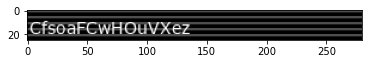

In [28]:
img,label = encode_single_image(os.path.join(img_folder, 'CfsoaFCwHOuVXez.png'), 'CfsoaFCwHOuVXez', False, True)

In [29]:
def create_train_valid_dataset():
    X,y = [],[]
    for _, _, files in os.walk(img_folder):
        for f in files: 
            if not f.endswith('.png'):
                continue
            #print(f)
            label = f.split('.')[0]
            img,label = encode_single_image(os.path.join(img_folder, f), label,crop=False,show=False)
            X.append(img)
            y.append(label)
    X,y = np.array(X).astype('float32'), np.array(y)
    X_train,X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, shuffle = True, random_state = 42)
    return X_train.astype('float32'), X_val.astype('float32'), y_train, y_val
    #return  np.asarray(X_train).astype('float32'),np.asarray(X_val).astype('float32'), np.asarray(y_train).astype(int), np.asarray(y_val).astype(int)



In [30]:
X_train,X_val, y_train, y_val  = create_train_valid_dataset()
print(X_train.shape,X_val.shape, y_train.shape, y_val.shape)

(1800, 280, 25, 1) (200, 280, 25, 1) (1800,) (200,)


/var/folders/nm/lm6vpz5s5v7_bt4xx0jq3fq00000gn/T/ipykernel_5490/2744048437.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X,y = np.array(X).astype('float32'), np.array(y)


Text(0.5, 1.0, '[6, 6, 48, 36, 51, 35, 5, 46, 15, 41, 41, 23, 3, 41, 21, 14]')

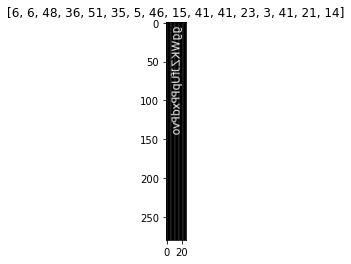

In [31]:
index = 11
plt.imshow(X_train[index], cmap = 'gray')
plt.title(y_train[index])

In [32]:
## Dimension : (280, 25) -> (25,12,64) -> (nb character, 25*12*64/nb_character) -> (nb_character, len(letters))

In [33]:
def build_model2():
    input_img = layers.Input(shape = (WIDTH,HEIGHT,1), name = 'image', dtype = 'float32')
    x = layers.Conv2D(32,(3,3), activation = "relu", kernel_initializer = "he_normal", 
                      padding = "same", name = "Conv1")(input_img)
    x = layers.MaxPooling2D((2,2), name = "pool1")(x)
    x = layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", 
                      padding = "same", name = "Conv2")(x)
    x = layers.MaxPooling2D((2,2), name = "pool2")(x)
    x = layers.Reshape(target_shape = (5,-1), name = 'reshape')(x)
    x = layers.Dense(256, activation = 'relu', name = "dense1")(x)
    x = layers.Dense(64, activation = 'relu', name = 'dense2')(x)
    output = layers.Dense(len(letters), activation = 'softmax', name = 'dense3')(x)
    model = keras.models.Model(inputs = input_img, outputs = output, name = 'ocr')
    #model = keras.models.Model(inputs = input_img, outputs = output, name = 'ocr')
    model.compile(optimizer = keras.optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = 'accuracy')
    return model

In [34]:
def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = layers.Conv2D(
        64, 3, padding='same', activation='relu', name='conv1')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool1')(x)

    x = layers.Conv2D(
        128, 3, padding='same', activation='relu', name='conv2')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool2')(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)
    x = layers.Conv2D(
        256, 3, padding='same', activation='relu', name='conv4')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool4')(x)

    x = layers.Conv2D(512, 3, padding='same', use_bias=False, name='conv5')(x)
    x = layers.BatchNormalization(name='bn5')(x)
    x = layers.Activation('relu', name='relu5')(x)
    x = layers.Conv2D(
        512, 3, padding='same', activation='relu', name='conv6')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool6')(x)

    x = layers.Conv2D(512, 2, use_bias=False, name='conv7')(x)
    x = layers.BatchNormalization(name='bn7')(x)
    x = layers.Activation('relu', name='relu7')(x)

    x = layers.Reshape((-1, 512), name='reshape7')(x)
    return x


def build_model(num_classes,
                weight=None,
                preprocess=None,
                postprocess=None,
                img_shape=(32, None, 3),
                model_name='crnn'):
    x = img_input = keras.Input(shape=img_shape)
    if preprocess is not None:
        x = preprocess(x)
    
    x = vgg_style(x)
    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm1')(x)
    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm2')(x)
    x = layers.Dense(units=num_classes, name='logits')(x)
    
    if postprocess is not None:
        x = postprocess(x)

    model = keras.Model(inputs=img_input, outputs=x, name=model_name)
    if weight is not None:
        model.load_weights(weight, by_name=True, skip_mismatch=True)
    return model

In [35]:
class CTCLoss(keras.losses.Loss):
    """ A class that wraps the function of tf.nn.ctc_loss. 
    
    Attributes:
        logits_time_major: If False (default) , shape is [batch, time, logits], 
            If True, logits is shaped [time, batch, logits]. 
        blank_index: Set the class index to use for the blank label. default is
            -1 (num_classes - 1). 
    """

    def __init__(self, logits_time_major=False, blank_index=-1, 
                 name='ctc_loss'):
        super().__init__(name=name)
        self.logits_time_major = logits_time_major
        self.blank_index = blank_index

    def call(self, y_true, y_pred):
        """ Computes CTC (Connectionist Temporal Classification) loss. work on
        CPU, because y_true is a SparseTensor.
        """
        y_true = tf.cast(y_true, tf.int32)
        y_pred_shape = tf.shape(y_pred)
        logit_length = tf.fill([y_pred_shape[0]], y_pred_shape[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=self.blank_index)
        return tf.math.reduce_mean(loss)

In [36]:
class SequenceAccuracy(keras.metrics.Metric):
    def __init__(self, name='sequence_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
                
    def update_state(self, y_true, y_pred, sample_weight=None):

        def sparse2dense(tensor, shape):
            tensor = tf.sparse.reset_shape(tensor, shape)
            tensor = tf.sparse.to_dense(tensor, default_value=-1)
            tensor = tf.cast(tensor, tf.float32)
            return tensor

        y_true_shape = tf.shape(y_true)
        batch_size = y_true_shape[0]
        y_pred_shape = tf.shape(y_pred)
        max_width = tf.math.maximum(y_true_shape[1], y_pred_shape[1])
        logit_length = tf.fill([batch_size], y_pred_shape[1])      
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(y_pred, perm=[1, 0, 2]),
            sequence_length=logit_length)
        y_true = sparse2dense(y_true, [batch_size, max_width])
        y_pred = sparse2dense(decoded[0], [batch_size, max_width])
        num_errors = tf.math.reduce_any(
            tf.math.not_equal(y_true, y_pred), axis=1)
        num_errors = tf.cast(num_errors, tf.float32)
        num_errors = tf.math.reduce_sum(num_errors)
        batch_size = tf.cast(batch_size, tf.float32)
        self.total.assign_add(batch_size)
        self.count.assign_add(batch_size - num_errors)

    def result(self):
        return self.count / self.total

    def reset_states(self):
        self.count.assign(0)
        self.total.assign(0)

In [23]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.0001, decay_steps= 600_000, alpha=0.01, name="Cosine")
    model = build_model(len(letters),weight=None,img_shape=[32, None, 3])

    model.compile(optimizer=keras.optimizers.Adam(lr_schedule),loss=CTCLoss(), metrics=[SequenceAccuracy()])

model.summary()
"""
model_prefix = '{epoch}_{val_loss:.4f}_{val_sequence_accuracy:.4f}'
model_path = f'{args.save_dir}/{model_prefix}.h5'
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path,
                                    save_weights_only=True),
    keras.callbacks.TensorBoard(log_dir=f'{args.save_dir}/logs',
                                **config['tensorboard'])
]
"""



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, None, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 32, None, 64)      1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, None, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 16, None, 128)     73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, None, 128)      0         
                                                                 
 conv3 (Conv2D)              (None, 8, None, 256)      294912    
                          

"\nmodel_prefix = '{epoch}_{val_loss:.4f}_{val_sequence_accuracy:.4f}'\nmodel_path = f'{args.save_dir}/{model_prefix}.h5'\ncallbacks = [\n    keras.callbacks.ModelCheckpoint(model_path,\n                                    save_weights_only=True),\n    keras.callbacks.TensorBoard(log_dir=f'{args.save_dir}/logs',\n                                **config['tensorboard'])\n]\n"

In [17]:
X_train,X_val, y_train, y_val = create_train_valid_dataset()
#history = model.fit(x = X_train, y = y_train, validation_data=(X_val, y_val), epochs = 10) 
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
history = model.fit(x = [X_train,y_train],
                    y = y_train,
                    validation_data = ([X_val,y_val],y_val),
                    epochs = 10,
                    callbacks = [early_stopping])

Model: "crnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, None, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 32, None, 64)      1792      
                                                                 
 pool1 (MaxPooling2D)        (None, 16, None, 64)      0         
                                                                 
 conv2 (Conv2D)              (None, 16, None, 128)     73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 8, None, 128)      0         
                                                                 
 conv3 (Conv2D)              (None, 8, None, 256)      294912    
                                                                 
 bn3 (BatchNormalization)    (None, 8, None, 256)      1024   

In [668]:
X_train,X_val, y_train, y_val = create_train_valid_dataset()
history = model.fit(x = X_train, y = y_train, validation_data=(X_val, y_val), epochs = 30) 

/var/folders/nm/lm6vpz5s5v7_bt4xx0jq3fq00000gn/T/ipykernel_17125/2744048437.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X,y = np.array(X).astype('float32'), np.array(y)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.add_subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

In [ ]:
y_pred = model.predict(X_val)
y_pred_true = np.argmax(y_pred,axis = 2)

In [ ]:
np.sum(y_pred_true==y_val)/(y_pred.shape[0] * y_pred.shape[1])

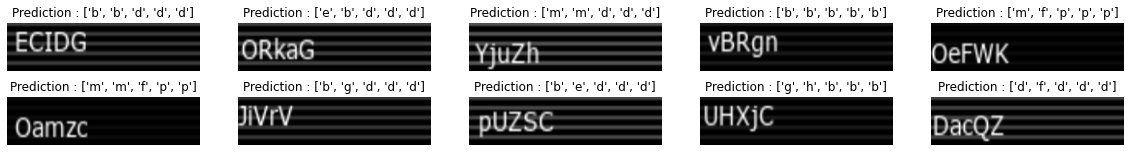

In [618]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=2)
num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    #plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    #print(y_pred[i])
    plt.title('Prediction : ' + str(list(map(lambda x:letters[x], y_pred[i]))))
    plt.axis('off')
plt.show() 

In [528]:
class CTCLayer(layers.Layer):
    
    def __init__(self,name = None):
        super().__init__(name = name)
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = 'int64')
        input_len = tf.cast(tf.shape(y_pred)[1], dtype = 'int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype = 'int64')
        
        input_len *= tf.ones(shape = (batch_len, 1), dtype = 'int64')
        label_len *= tf.ones(shape = (batch_len, 1), dtype = 'int64')
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        
        #y_pred_true = tf.math.argmax(y_pred,axis = 2)
        #np.sum(y_pred_true==y_val)/(y_pred.shape[0] * y_pred.shape[1])
        
        #self.add_metric(tf.add(y_pred_true==y_true)/(y_pred.shape[0] * y_pred.shape[1]), name = 'metric')
        self.add_loss(loss)
        return y_pred

In [529]:
def build_lstm_cnn_model():
    input_img = layers.Input(shape = (WIDTH,HEIGHT,1), name = 'image', dtype = 'float32')
    labels = layers.Input(shape = (None,), name = "label", dtype = 'float32')
    x = layers.Conv2D(32,(3,3), activation = "relu", kernel_initializer = "he_normal", 
                      padding = "same", name = "Conv1")(input_img)
    x = layers.MaxPooling2D((2,2), name = "pool1")(x)
    x = layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer = "he_normal", 
                      padding = "same", name = "Conv2")(x)
    x = layers.MaxPooling2D((2,2), name = "pool2")(x)
    x = layers.Reshape(target_shape = (WIDTH//4,-1), name = 'reshape')(x)
    x = layers.Dense(64, activation = 'relu', name = 'dense1')(x)
    x = layers.Dropout(.2)(x)
    x = layers.Bidirectional(layers.LSTM(128,return_sequences = True, dropout = .2))(x)
    x = layers.Bidirectional(layers.LSTM(64,return_sequences = True, dropout = .25))(x)
    x = layers.Dense(len(letters) + 1, activation = 'softmax', kernel_initializer='he_normal', name = 'dense2')(x)
    
    output = CTCLayer(name = "ctc_loss")(labels,x)
    
    model = keras.models.Model(inputs = [input_img,labels], outputs = output, name = 'ocr_cnn_bilstm')
    #model = keras.models.Model(inputs = input_img, outputs = output, name = 'ocr')
    #model.compile(optimizer = keras.optimizers.Adam())
    model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.002, decay = 1e-6, momentum = 0.9, nesterov = True, clipnorm=5))
    return model

In [530]:
model = build_lstm_cnn_model()
model.summary()

Model: "ocr_cnn_bilstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 280, 25, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 280, 25, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 140, 12, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 140, 12, 64)  18496       ['pool1[0][0]']     

In [535]:
X_train,X_val, y_train, y_val = create_train_valid_dataset()
#history = model.fit(x = X_train, y = y_train, validation_data=(X_val, y_val), epochs = 10) 
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
history = model.fit(x = [X_train,y_train],
                    y = y_train,
                    validation_data = ([X_val,y_val],y_val),
                    epochs = 100,
                    callbacks = [early_stopping])

Epoch 1/100
29/29 [==============================] - 10s 329ms/step - loss: 21.4600 - val_loss: 21.4996
Epoch 2/100
29/29 [==============================] - 9s 327ms/step - loss: 21.4531 - val_loss: 21.4929
Epoch 3/100
29/29 [==============================] - 10s 358ms/step - loss: 21.4534 - val_loss: 21.5159
Epoch 4/100
29/29 [==============================] - 10s 350ms/step - loss: 21.4474 - val_loss: 21.4962
Epoch 5/100
29/29 [==============================] - 10s 352ms/step - loss: 21.4386 - val_loss: 21.4920
Epoch 6/100
29/29 [==============================] - 10s 351ms/step - loss: 21.4472 - val_loss: 21.5051
Epoch 7/100
29/29 [==============================] - 10s 353ms/step - loss: 21.4483 - val_loss: 21.4856
Epoch 8/100
29/29 [==============================] - 11s 372ms/step - loss: 21.4406 - val_loss: 21.4884
Epoch 9/100
29/29 [==============================] - 10s 359ms/step - loss: 21.4350 - val_loss: 21.5011
Epoch 10/100
29/29 [==============================] - 10s 351ms/s

29/29 [==============================] - 11s 369ms/step - loss: 13.9286 - val_loss: 18.5985
Epoch 80/100
29/29 [==============================] - 10s 346ms/step - loss: 13.7752 - val_loss: 18.5638
Epoch 81/100
29/29 [==============================] - 10s 350ms/step - loss: 13.5585 - val_loss: 18.5102
Epoch 82/100
29/29 [==============================] - 10s 342ms/step - loss: 13.3497 - val_loss: 18.6013
Epoch 83/100
29/29 [==============================] - 11s 367ms/step - loss: 13.1355 - val_loss: 18.6500
Epoch 84/100
29/29 [==============================] - 11s 365ms/step - loss: 13.0216 - val_loss: 18.6410
Epoch 85/100
29/29 [==============================] - 10s 347ms/step - loss: 12.7500 - val_loss: 18.6318
Epoch 86/100
29/29 [==============================] - 10s 343ms/step - loss: 12.6029 - val_loss: 18.7462
Epoch 87/100
29/29 [==============================] - 10s 339ms/step - loss: 12.3504 - val_loss: 18.7152
Epoch 88/100
29/29 [==============================] - 10s 343ms/step

In [536]:
y_val

array([[35, 46,  3, 36, 50],
       [31, 50, 37, 30, 48],
       [19, 12, 13, 28, 10],
       [ 5,  4, 27, 46, 32],
       [ 5, 12, 24,  8, 49],
       [26,  5, 34, 10, 14],
       [14, 25, 47,  4, 24],
       [15, 42, 45, 46, 34],
       [ 8,  9, 18, 48,  6],
       [34, 15, 13,  2, 19],
       [17,  5, 22, 36, 16],
       [22, 43, 19, 11, 40],
       [34, 25, 47, 39,  3],
       [12, 42, 13, 16,  3],
       [34, 16, 12, 20, 41],
       [33, 46, 49, 30, 44],
       [11, 42, 24, 36, 21],
       [23, 24, 10, 36, 10],
       [18, 29, 24, 42, 32],
       [34,  1, 32, 48, 13],
       [12, 26, 17, 29,  4],
       [48, 26, 31,  6,  8],
       [ 3, 29,  3, 28, 45],
       [42, 12, 25, 30, 10],
       [28, 46, 42,  6, 48],
       [15,  3, 37, 47, 49],
       [46, 11, 29, 16, 10],
       [49, 44,  6, 12, 31],
       [13, 16,  5, 48, 11],
       [29, 16,  7, 36, 14],
       [27, 32, 45, 15, 34],
       [11, 43, 48, 39, 24],
       [ 1, 27, 33, 19, 34],
       [ 4, 27, 14, 23,  5],
       [ 4, 35

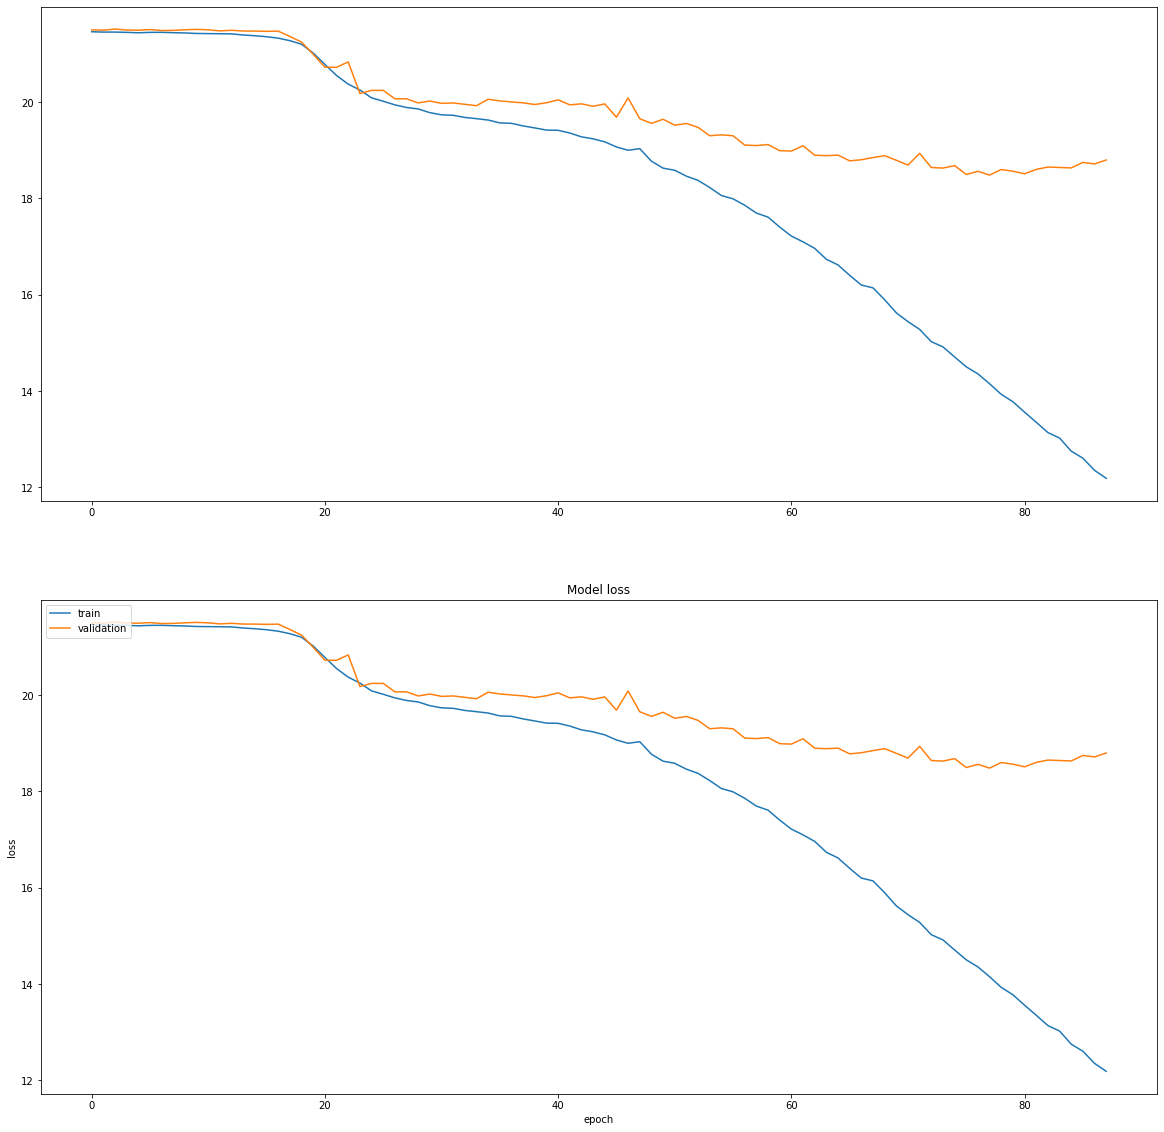

In [537]:
fig, axs = plt.subplots(2, figsize=(20,20))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('lo')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

In [ ]:
history.history

In [503]:
prediction_model = keras.models.Model(model.get_layer(name = "image").input, model.get_layer(name = "dense2").output)

prediction_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 280, 25, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 280, 25, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 140, 12, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 140, 12, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 70, 6, 64)         0         
                                                                 
 reshape (Reshape)           (None, 70, 384)           0         
                                                                 
 dense1 (Dense)              (None, 70, 64)            24640 

In [506]:
#print(y_val.shape)
y_pred = prediction_model.predict(X_val)
print(y_pred.shape)
y_pred = keras.backend.ctc_decode(y_pred, input_length = np.ones(y_val.shape[0] *), greedy = True)

(10, 70, 53)
